# Forecasting Food Demand 

## Applying Neural Networks to the Meal kit Industry

So this is going to overfit

![alt text](https://media.self.com/photos/5dfd1730e313510008a38574/16:9/w_1280,h_720,c_limit/best%20meal%20kits%20lede.png)

# Get Data
Data available from: https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/

You'll have to sign up. Then go to 'Problem Statement' and scroll to the bottom. Download the train zip file and the test csv file.

In [1]:
%reload_ext autoreload
%autoreload 2
from fastai.tabular import *

In [5]:
# mount google drive (if in google colab)
import sys

IN_COLAB = 'google.colab' in sys.modules

if (IN_COLAB):
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import glob
import shutil

if (IN_COLAB):
  files = glob.glob('/content/drive/My Drive/food_demand_prediction/*.zip')
  for file in files:
    shutil.copyfile(file, '/content/zipfile.zip')

In [7]:
!unzip \*.zip

Archive:  zipfile.zip
  inflating: fulfilment_center_info.csv  
  inflating: meal_info.csv           
  inflating: train.csv               


# Neural Network with Category embeddings

## Data preparation

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/food_demand_prediction/test_QoiMO9B.csv')
orig_test_cols = test_df.columns

In [ ]:
import datetime
import math

# competition starts from 2018
start_year = 2018

def convert_week_number_to_date(week_number):

  # round down
  years_adding = int(week_number/52)
  new_year = start_year + years_adding

  # remainder
  remainder = week_number %52

  d = str(new_year)+"-W"+str(remainder)
  r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
  # print(r)

  return r.date()

train_df['Date'] = train_df['week'].apply(lambda text: convert_week_number_to_date(text))
test_df['Date'] = test_df['week'].apply(lambda text: convert_week_number_to_date(text))

In [ ]:
train_df['Date'] =  pd.to_datetime(train_df['Date'], format='%Y-%m-%d')
test_df['Date'] =  pd.to_datetime(test_df['Date'], format='%Y-%m-%d')

In [ ]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,Date
0,1379560,1,55,1885,136.83,152.29,0,0,177,2018-01-01
1,1466964,1,55,1993,136.83,135.83,0,0,270,2018-01-01
2,1346989,1,55,2539,134.86,135.86,0,0,189,2018-01-01
3,1338232,1,55,2139,339.50,437.53,0,0,54,2018-01-01
4,1448490,1,55,2631,243.50,242.50,0,0,40,2018-01-01


In [ ]:
meal = pd.read_csv('meal_info.csv')
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [ ]:
train_df = train_df.merge(meal,on='meal_id')
test_df = test_df.merge(meal,on='meal_id')
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,Date,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,2018-01-01,Beverages,Thai
1,1040403,1,24,1885,136.83,136.83,0,0,1498,2018-01-01,Beverages,Thai
2,1103215,1,11,1885,136.83,136.83,0,0,959,2018-01-01,Beverages,Thai
3,1034383,1,83,1885,121.31,120.31,0,1,1025,2018-01-01,Beverages,Thai
4,1118999,1,32,1885,114.52,113.52,0,1,445,2018-01-01,Beverages,Thai


In [ ]:
fulfilment_df = pd.read_csv('fulfilment_center_info.csv')
fulfilment_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [ ]:
train_df = train_df.merge(fulfilment_df,on='center_id')
test_df = test_df.merge(fulfilment_df,on='center_id')
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,Date,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,2018-01-01,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,2018-01-08,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,2018-01-15,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,2018-01-22,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,2018-01-29,Beverages,Thai,647,56,TYPE_C,2.0


In [ ]:
n = len(train_df); n

456548

In [ ]:
train_df = add_datepart(train_df, "Date", drop=False)
test_df = add_datepart(test_df, "Date", drop=False)

## Feature Engineering

In [ ]:
def feature_engineering(df_train, df_test):

  # inspired by: https://varunbpatil.github.io/2018/12/25/genpact-ml-hackathon.html

  # percent difference between base price and checkout price.
  df_train['price_diff_percent'] = \
          (df_train['base_price'] - df_train['checkout_price']) / \
          df_train['base_price']

  df_test['price_diff_percent'] = \
          (df_test['base_price'] - df_test['checkout_price']) / \
          df_test['base_price']


  # Convert email and homepage features into a single feature - 'email_plus_homepage'.
  df_train['email_plus_homepage'] = \
          df_train['emailer_for_promotion'] + \
          df_train['homepage_featured']

  df_test['email_plus_homepage'] = \
          df_test['emailer_for_promotion'] + \
          df_test['homepage_featured']

  # df_train = df_train.apply(lambda row: emailer_and_homepage(row))
  # df_test = df_test.apply(lambda row: emailer_and_homepage(row))

  return df_train,df_test

train_df,test_df = feature_engineering(df_train=train_df, df_test=test_df)

## Preparing full data set

In [ ]:
len(train_df),len(test_df)

(456548, 32573)

In [ ]:
# Fill Missing values
# Encode categorical variables
# Normalize continous variables
procs=[FillMissing, Categorify, Normalize]

cont_vars = [i for i in ['checkout_price', 
             'base_price', 
             'Elapsed',
             'week_sin', 
             'week_cos',  
             'price_diff_percent'] if i in train_df.columns and i in test_df.columns]

cat_vars = [i for i in ['week', 'center_id', 'meal_id',
       'emailer_for_promotion', 'homepage_featured', 
       'category', 'cuisine', 'city_code', 'region_code', 'center_type',
       'op_area', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start',
       'email_plus_homepage'] if i in train_df.columns and i in test_df.columns]

dep_var = 'num_orders'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()


bs = 2**12 # max this out
path = Path('.')

# create tabular data bunch
# validation set will be 5000 rows (ordered)
# label cls
data = (TabularList.from_df(df, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_idx(list(range(1000,1000+5000))) 
                .label_from_df(cols=dep_var, label_cls=FloatList, log = True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs = procs))
                .databunch(bs=bs))


In [ ]:
df[dep_var].value_counts()

13      12397
15      12294
14      12270
28      11548
27      11462
        ...  
4819        1
7262        1
6750        1
7007        1
5629        1
Name: num_orders, Length: 1250, dtype: int64

In [ ]:
data

TabularDataBunch;

Train: LabelList (451548 items)
x: TabularList
week 1; center_id 55; meal_id 1885; emailer_for_promotion 0; homepage_featured 0; category Beverages; cuisine Thai; city_code 647; region_code 56; center_type TYPE_C; op_area 2.0; Year 2018; Month 1; Week 1; Day 1; Dayofweek 0; Dayofyear 1; Is_month_end False; Is_month_start True; Is_quarter_end False; Is_quarter_start True; Is_year_end False; Is_year_start True; email_plus_homepage 0; checkout_price -1.2775; base_price -1.2558; Elapsed -1.7750; price_diff_percent 0.3910; ,week 2; center_id 55; meal_id 1885; emailer_for_promotion 0; homepage_featured 0; category Beverages; cuisine Thai; city_code 647; region_code 56; center_type TYPE_C; op_area 2.0; Year 2018; Month 1; Week 2; Day 8; Dayofweek 0; Dayofyear 8; Is_month_end False; Is_month_start False; Is_quarter_end False; Is_quarter_start False; Is_year_end False; Is_year_start False; email_plus_homepage 0; checkout_price -1.2841; base_price -1.2558; Elapsed -1.7511; pri

In [ ]:
data.show_batch()

week,center_id,meal_id,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,email_plus_homepage,checkout_price,base_price,Elapsed,price_diff_percent,target
3,174,1803,0,0,Extras,Thai,700,56,TYPE_A,7.0,2018,1,3,15,0,15,False,False,False,False,False,False,0,-0.8780,-0.9842,-1.7273,-0.5928,5.17615
125,124,2306,0,0,Pasta,Italian,590,56,TYPE_C,4.0,2020,5,22,25,0,146,False,False,False,False,False,False,0,-0.5865,-0.1150,1.2067,1.9394,3.295837
32,152,2581,0,0,Pizza,Continental,576,34,TYPE_B,4.0,2018,8,32,6,0,218,False,False,False,False,False,False,0,2.0138,1.7741,-1.0355,-0.5167,4.9972124
61,67,1311,0,0,Extras,Thai,638,56,TYPE_B,7.0,2019,3,10,4,0,63,False,False,False,False,False,False,0,-1.3285,-1.1950,-0.3199,1.2908,6.289716
111,153,1971,0,0,Sandwich,Italian,590,56,TYPE_A,3.9,2020,2,8,17,0,48,False,False,False,False,False,False,0,-0.0666,-0.1995,0.8727,-0.5029,5.09375


## Model

In [ ]:
max_log_y = np.log(np.max(train_df[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [ ]:
# emb_szs={'native-country': 10}
min_size = 50
emb_szs = {cat_vars[i]:min(len(df[cat_vars[i]].value_counts().index)//2, min_size) for i in range(1, len(cat_vars))}
emb_szs

{'Day': 15,
 'Dayofweek': 0,
 'Dayofyear': 50,
 'Is_month_end': 1,
 'Is_month_start': 1,
 'Is_quarter_end': 1,
 'Is_quarter_start': 1,
 'Is_year_end': 1,
 'Is_year_start': 1,
 'Month': 6,
 'Week': 26,
 'Year': 1,
 'category': 7,
 'center_id': 38,
 'center_type': 1,
 'city_code': 25,
 'cuisine': 2,
 'email_plus_homepage': 1,
 'emailer_for_promotion': 1,
 'homepage_featured': 1,
 'meal_id': 25,
 'op_area': 15,
 'region_code': 4}

In [ ]:
def get_learner(emb_szs=emb_szs, layers=[1000,500], ps=[0.02,0.04], emb_drop=0.08):

  return (tabular_learner(data,
                          layers=layers,
                          ps=ps,
                          emb_drop=emb_drop,
                          y_range=y_range,
                          emb_szs=emb_szs,
                          metrics=exp_rmspe))

In [ ]:
learn = get_learner(emb_szs=emb_szs, layers = [1000,500], ps = [0.2,0.4], emb_drop = 0.04)

In [ ]:
from google.colab import files

def copy_to_drive():

  learn.export()
  model_path = learn.path/'export.pkl'

  # if in colab copy to drive
  if (IN_COLAB):
  
    !mkdir /content/drive/"My Drive"/food_demand_pred
    !cp $model_path /content/drive/"My Drive"/food_demand_pred/

In [ ]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(146, 26)
    (1): Embedding(78, 38)
    (2): Embedding(52, 25)
    (3): Embedding(3, 1)
    (4): Embedding(3, 1)
    (5): Embedding(15, 7)
    (6): Embedding(5, 2)
    (7): Embedding(52, 25)
    (8): Embedding(9, 4)
    (9): Embedding(4, 1)
    (10): Embedding(31, 15)
    (11): Embedding(4, 1)
    (12): Embedding(13, 6)
    (13): Embedding(53, 26)
    (14): Embedding(32, 15)
    (15): Embedding(2, 0)
    (16): Embedding(146, 50)
    (17): Embedding(3, 1)
    (18): Embedding(3, 1)
    (19): Embedding(3, 1)
    (20): Embedding(3, 1)
    (21): Embedding(3, 1)
    (22): Embedding(3, 1)
    (23): Embedding(4, 1)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=254, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_r

## Targetted Gridsearch

Results saved to a file called `data.json` in the same directory. 

In [ ]:
# this will take a long time (~45 mins)

from itertools import product
from tqdm.notebook import tqdm

lrs = []
losses = []
wds = []
ps = []
emb_drops = []
layers = []
iter_count = 600
curr_wd = 1e-3
layers = [1000,500]
# layers = [500,250]
ps = [0.002,0.02]
emb_drop = 0.04
min_loss = 1000

params = {
    'wd':[i for i in np.linspace(0,1,11)],
    'ps':[[0.002,0.02], [0.02,0.2]],
    'emb_drop': [0.04, 0.06, 0.08, 0.1],
    'layers': [[1000, 500], [500, 250], [250, 125], [200, 100], [100, 50], [50, 25]]
}

parameter_combinations = []

for i in tqdm(list(product(*params.values()))):

  curr_wd = i[0]
  curr_ps = i[1]
  curr_emb_drop = i[2]
  curr_layers = i[3]

  print("curr_wd = {}\ncurr_ps = {}\ncurr_emb_drop = {}\ncurr_layers = {}\n".format(i[0], i[1], i[2], i[3]))

  learner = get_learner(emb_szs=emb_szs, layers = curr_layers, ps = curr_ps, emb_drop = curr_emb_drop) 

  learner.lr_find(wd=curr_wd, num_it=15)

  curr_lowest_loss = min(learner.recorder.losses)

  if (curr_lowest_loss<min_loss):

    min_loss = curr_lowest_loss

    wds.append(curr_wd)
    layers.append(curr_layers)
    emb_drops.append(curr_emb_drop)
    ps.append(curr_ps)
    lrs.append(learner.recorder.lrs)
    losses.append(learner.recorder.losses)

    combination = [dict(curr_wd=curr_wd, curr_layers=curr_layers, curr_emb_drop=curr_emb_drop,\
                        curr_ps=curr_ps, min_loss=min_loss.item())]

    parameter_combinations += combination


In [ ]:
import json
with open('data.json', 'w') as fp:
    json.dump(parameter_combinations, fp)

In [ ]:
from matplotlib import rcParams, cycler

N = len(parameter_combinations)
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))

_, axes = plt.subplots(1,1, figsize = (10,10))
min_y = 0.5
max_y = 3
for i in range(len(losses)):
  axes.plot(lrs[i], losses[i])
  min_y = min(np.asarray(losses[i]).min(), min_y)
axes.set_ylabel("Loss")
axes.set_xlabel("Learning Rate")
axes.set_xscale('log')
axes.set_xlim((1e-3,1e-1*10))
axes.set_ylim((min_y - 0.02,max_y))



axes.legend(layers)

legend = axes.legend(wds, loc='upper right')
axes.add_artist(legend)

legend = axes.legend(ps, loc='upper left')
axes.add_artist(legend)


legend = axes.legend(parameter_combinations, loc='upper left')
axes.add_artist(legend)

axes.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))


## Training

### main training

In [ ]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 1e-2
lr

0.01

In [ ]:
learner = get_learner(emb_szs=emb_szs, layers = [1000, 500], ps = [0.02,0.2], emb_drop = 0.08) 

In [ ]:
learn.fit_one_cycle(5, lr, wd = 0.6)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.794834,0.527638,1.394083,00:40
1,0.337046,0.393367,1.015117,00:38
2,0.269606,0.340642,0.889653,00:39
3,0.246331,0.319316,0.967042,00:39
4,0.225082,0.301406,0.918722,00:39


In [ ]:
learn.save('1')

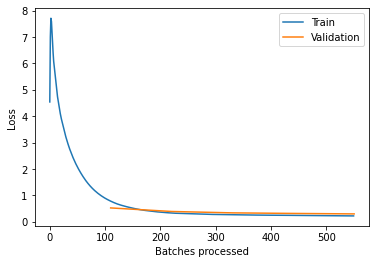

In [ ]:
learn.load('1')
learn.recorder.plot_losses()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(5, lr, wd = 0.6)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.242569,0.430389,1.384022,00:39
1,0.259906,0.392157,0.942048,00:39
2,0.250479,0.312155,0.848800,00:39
3,0.233924,0.288306,0.843052,00:39
4,0.216123,0.288398,0.872830,00:39


In [ ]:
learn.save('2')

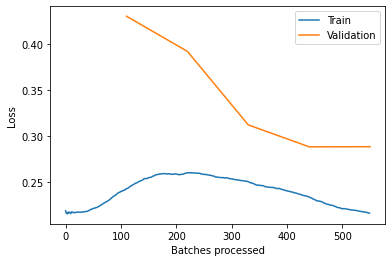

In [ ]:
learn.load('2')
learn.recorder.plot_losses()

In [ ]:
lr = 1e-4

In [ ]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.208563,0.287762,0.878464,00:40
1,0.208334,0.287900,0.879273,00:40
2,0.206633,0.288176,0.891041,00:40
3,0.205744,0.286725,0.885953,00:39
4,0.205233,0.286854,0.887262,00:39


In [ ]:
learn.save('3')

AttributeError: ignored

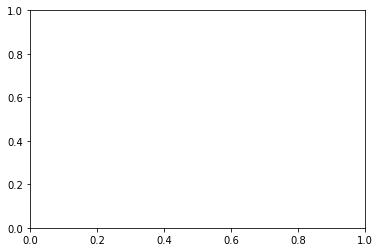

In [ ]:
learn.load('3')
learn.recorder.plot_losses()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.205200,0.286195,0.887856,00:40
1,0.205745,0.294301,0.928834,00:40
2,0.207058,0.290699,0.906366,00:39
3,0.207849,0.273724,0.829066,00:39
4,0.207573,0.276190,0.836388,00:39
5,0.204099,0.274907,0.842802,00:39
6,0.202215,0.270555,0.808639,00:39
7,0.199274,0.286915,0.859098,00:39
8,0.196542,0.275454,0.863882,00:39
9,0.193491,0.284747,0.882402,00:40


In [ ]:
learn.save('4')

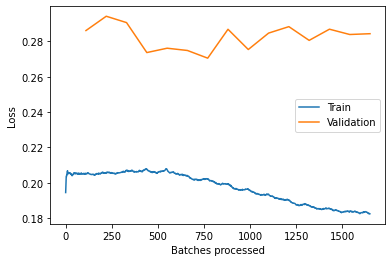

In [ ]:
learn.load('4')
learn.recorder.plot_losses()

In [ ]:
copy_to_drive()

## Predict

In [ ]:
test_preds = learn.get_preds(DatasetType.Test)
test_preds

[tensor([[5.1426],
         [5.2189],
         [5.2689],
         ...,
         [3.8276],
         [3.7355],
         [3.7832]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [ ]:
test_df["num_orders"]=np.exp(test_preds[0].data).numpy().T[0]
# test_df[["Id","num_orders"]]=test_df[["Id","num_order"]].astype("int")

In [ ]:
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,Date,category,cuisine,city_code,region_code,center_type,op_area,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,price_diff_percent,email_plus_homepage,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,2020-10-19,Beverages,Thai,647,56,TYPE_C,2.0,2020,10,43,19,0,293,False,False,False,False,False,False,1603065600,0.006285,0,171.168045
1,1262649,147,55,1885,159.11,159.11,0,0,2020-10-26,Beverages,Thai,647,56,TYPE_C,2.0,2020,10,44,26,0,300,False,False,False,False,False,False,1603670400,0.000000,0,184.727646
2,1453211,149,55,1885,157.14,158.14,0,0,2020-11-09,Beverages,Thai,647,56,TYPE_C,2.0,2020,11,46,9,0,314,False,False,False,False,False,False,1604880000,0.006324,0,194.197388
3,1262599,150,55,1885,159.14,157.14,0,0,2020-11-16,Beverages,Thai,647,56,TYPE_C,2.0,2020,11,47,16,0,321,False,False,False,False,False,False,1605484800,-0.012728,0,185.959991
4,1495848,151,55,1885,160.11,159.11,0,0,2020-11-23,Beverages,Thai,647,56,TYPE_C,2.0,2020,11,48,23,0,328,False,False,False,False,False,False,1606089600,-0.006285,0,167.116623


## To CSV

In [ ]:
test_df[["id","num_orders"]].to_csv("mealkit_submission.csv",index=False)

In [ ]:
!mkdir /content/drive/"My Drive"/mealkit_nn/
!cp /content/mealkit_submission.csv /content/drive/"My Drive"/mealkit_nn/

# Other models

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
# inspired by https://www.martinalarcon.org/2018-12-31-b-water-pumps/

from category_encoders.binary import BinaryEncoder
class convert_tabular_learner_to_df():

  def __init__(self, cat_names, tabular_data_bunch):
    self.cat_names = cat_names
    self.tabular_data_bunch = tabular_data_bunch

  def driver(self):

    # convert tabular data to dataframe
    X_train, y_train = self.list_to_df(self.tabular_data_bunch.train_ds)
    X_valid, y_valid = self.list_to_df(self.tabular_data_bunch.valid_ds)

    # label encode data
    encoder = BinaryEncoder(cols = self.cat_names)
    X_train = encoder.fit_transform(X_train)
    X_valid = encoder.transform(X_valid)

    return X_train, X_valid, y_train, y_valid

  def list_to_df(self, tabular_learner):

    # create X df
    x_vals = np.concatenate([tabular_learner.x.codes, tabular_learner.x.conts], axis=1)
    cols = tabular_learner.x.cat_names + tabular_learner.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=cols)

    # reorder cols
    x_df = x_df[[c for c in tabular_learner.inner_df.columns if c in cols]]

    # create y labels
    cols = [i.obj for i in tabular_learner.y]
    y_vals = np.array(cols, dtype="float64")

    return x_df, y_vals


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
converter = convert_tabular_learner_to_df(cat_vars, data)
X_train, X_valid, y_train, y_valid = converter.driver()

In [ ]:
# from sklearn.model_selection import train_test_split

# X = df.drop('num_orders', axis = 1)
# y = df['num_orders']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
y_valid

array([6.068426, 5.648974, 5.497168, 5.09375 , ..., 6.838405, 7.114769, 6.238325, 7.276556])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

def rmspe_calc(y_true, y_pred):
    # Compute Root Mean Square Percentage Error between two arrays.
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))


models = [
  xgb.XGBRegressor(),
  lgb.LGBMRegressor(),
  RandomForestRegressor()
]

results = pd.DataFrame(columns=["Regressor", "RMSPE"])

for model in models:

  name = model.__class__.__name__
  
  model.fit(X_train, y_train)

  rmspe = rmspe_calc(y_valid, model.predict(X_valid))
  
  df2 = pd.DataFrame(
    {"Regressor": name, \
     "RMSPE": rmspe*100}, index = [0]
  )

  results = results.append(df2, ignore_index = True)

[04:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'Regressor RMSPE')

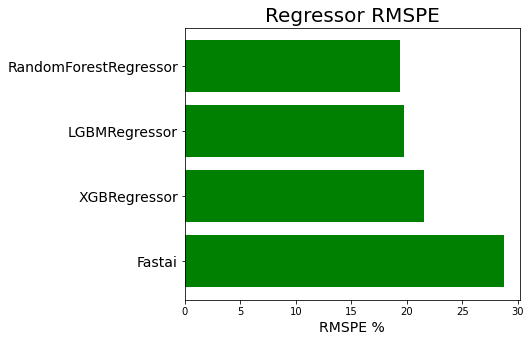

In [ ]:
results = results.append(pd.DataFrame({"Regressor": 'Fastai', "RMSPE": 0.287369*100}, index = [0]), ignore_index = True)

results = results.sort_values('RMSPE', ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.barh(results['Regressor'], results['RMSPE'], color="g")
ax.tick_params(axis="y", labelsize=14)
ax.set_xlabel('RMSPE %', fontsize=14)
ax.set_title('Regressor RMSPE', fontsize=20)

